In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from assimilation import EnKF, M3DVar, ExtendedKF, M4DVar, Hybrid3DEnVar
from model import lorenz63_fdm, M63

In [2]:
X_nature = np.load('./data/X_nature.npy')
X_ini = np.load('./data/X_ini.npy')
obs = np.load('./data/4DVar/obs_normal.npy')
ts = np.load('./data/time_span.npy')
Pb = np.load('./data/Pb.npy')
R = np.load('./data/R.npy')

dt = 0.01

# generate initial ensemble
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (3, N_ens)

def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

# normal

In [9]:
normal_rmse = {}

#### EnKF

In [10]:
da_rmse = []

for _ in range(10):
    obs_intv = 8
    obs = X_nature + np.random.randn(*X_nature.shape) * np.sqrt(2)
    obs = obs[:,::obs_intv]
    
    da = EnKF(lorenz63_fdm, dt)
    da.list_params()
    params = {
        'X_ens_ini': X_ens_ini,
        'obs': obs,
        'obs_interv': obs_intv,
        'R': R,
        'H_func': lambda arr: arr,
        'alpha': 0.3,
        'inflat': 1.5
    }
    da.set_params(**params)
    da.cycle()
    
    da_rmse.append(RMSE(da.analysis.mean(axis=0), X_nature).mean())

In [11]:
normal_rmse['EnKF'] = da_rmse

#### EKF

In [19]:
da_rmse = []

for _ in range(10):
    obs_intv = 8
    obs = X_nature + np.random.randn(*X_nature.shape) * np.sqrt(2)
    obs = obs[:,::obs_intv]

    da = ExtendedKF(lorenz63_fdm, dt)
    da.list_params()
    params = {
        'X_ini': X_ini,
        'obs': obs,
        'obs_interv': obs_intv,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'M': lambda x: M63(x, dt),
        'alpha': 0.3,
        'inflat': 1.5
    }
    da.set_params(**params)
    da.cycle()
    
    da_rmse.append(RMSE(da.analysis, X_nature).mean())

In [20]:
normal_rmse['EKF'] = da_rmse

#### 3DVAR

In [26]:
da_rmse = []

for _ in range(10):
    obs_intv = 8
    obs = X_nature + np.random.randn(*X_nature.shape) * np.sqrt(2)
    obs = obs[:,::obs_intv]

    da = M3DVar(lorenz63_fdm, dt)
    da.list_params()
    params = {
        'X_ini': X_ini,
        'obs': obs,
        'obs_interv': obs_intv,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
    }
    da.set_params(**params)
    da.cycle()
    
    da_rmse.append(RMSE(da.analysis, X_nature).mean())

In [27]:
normal_rmse['3DVar'] = da_rmse

#### 3DEnVar

In [35]:
da_rmse = []

for _ in range(10):
    obs_intv = 8
    obs = X_nature + np.random.randn(*X_nature.shape) * np.sqrt(2)
    obs = obs[:,::obs_intv]

    da = Hybrid3DEnVar(lorenz63_fdm, dt)
    da.list_params()
    params = {
        'X_ini': X_ini,
        'X_ens_ini': X_ens_ini,
        'obs': obs,
        'obs_interv': obs_intv,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'alpha': 0.3,
        'inflat': 1.5,
        'beta': 0.6
    }
    da.set_params(**params)
    da.cycle()
    
    da_rmse.append(RMSE(da.analysis_3dvar, X_nature).mean())

In [36]:
normal_rmse['3DEnVar'] = da_rmse

# Skew

In [42]:
from scipy.stats import skewnorm

def gen_skewnormal(mean, var, alpha, size, random_state=None):
    """generate random number by skewnorm, and adjust them into given mean and variance"""
    # generate standard skew normal distribution
    X = skewnorm.rvs(alpha, loc=0, scale=1, size=size, random_state=random_state)
    
    # theory expectation value (mean) and variance of standard skew normal distribution
    tmean = np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    tvar = 1 - 2/np.pi * alpha**2 / (1+alpha**2)

    # adjust var, then adjust mean
    X = np.sqrt(var/tvar) * X
    tmean = np.sqrt(var/tvar) * np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    X = X + mean - tmean
    
    return X

def gen_skewobs(nature, mean, var, alpha, obs_intv, random_state=None):
    """generate skew observations"""
    ndim, size = nature.shape
    
    if isinstance(mean, (int, float)):
        mean = [mean for _ in range(ndim)]
    if isinstance(var, (int, float)):
        var = [var for _ in range(ndim)]
    if isinstance(alpha, (int, float)):
        alpha = [alpha for _ in range(ndim)]
        
    if random_state is None:
        random_state = [np.random.randint(0, 100) for _ in range(ndim)]
    
    obs = np.zeros((ndim, size//obs_intv))
    for irow, (m, v, a, rst) in enumerate(zip(mean, var, alpha, random_state)):
        samples = gen_skewnormal(m, v, a, size, rst)
        #samples_tmp = samples.copy()
        #samples_tmp[::obs_intv] = 0
        #samples = samples - samples_tmp
        obs[irow,:] = (nature[irow,:] + samples)[::obs_intv]
        
    return obs

In [40]:
skew_rmse = {}

#### EnKF

In [45]:
alphas = [1.30, 1.55, 1.80, 2.05, 2.30, 2.55, 2.80, 3.05, 3.30]
alpha_rmse = []

for alpha in alphas:
    print(alpha)
    da_rmse = []
    
    for _ in range(10):
        obs_intv = 8
        obs = gen_skewobs(X_nature, 0, 2, alpha, obs_intv = 8)

        da = EnKF(lorenz63_fdm, dt)
        da.list_params()
        params = {
            'X_ens_ini': X_ens_ini,
            'obs': obs,
            'obs_interv': obs_intv,
            'R': R,
            'H_func': lambda arr: arr,
            'alpha': 0.3,
            'inflat': 1.5
        }
        da.set_params(**params)
        da.cycle()

        da_rmse.append(RMSE(da.analysis.mean(axis=0), X_nature).mean())
        
    alpha_rmse.append(np.mean(da_rmse))

1.3
1.55
1.8
2.05
2.3
2.55
2.8
3.05
3.3


In [46]:
skew_rmse['EnKF'] = alpha_rmse

#### EKF

In [50]:
alphas = [1.30, 1.55, 1.80, 2.05, 2.30, 2.55, 2.80, 3.05, 3.30]
alpha_rmse = []

for alpha in alphas:
    print(alpha)
    da_rmse = []
    
    for _ in range(10):
        obs_intv = 8
        obs = gen_skewobs(X_nature, 0, 2, alpha, obs_intv = 8)

        da = ExtendedKF(lorenz63_fdm, dt)
        da.list_params()
        params = {
            'X_ini': X_ini,
            'obs': obs,
            'obs_interv': obs_intv,
            'Pb': Pb,
            'R': R,
            'H_func': lambda arr: arr,
            'H': np.eye(3),
            'M': lambda x: M63(x, dt),
            'alpha': 0.3,
            'inflat': 1.5
        }
        da.set_params(**params)
        da.cycle()

        da_rmse.append(RMSE(da.analysis, X_nature).mean())
    
    alpha_rmse.append(np.mean(da_rmse))

1.3
1.55
1.8
2.05
2.3
2.55
2.8
3.05
3.3


In [51]:
skew_rmse['EKF'] = alpha_rmse

#### 3DVar

In [54]:
alphas = [1.30, 1.55, 1.80, 2.05, 2.30, 2.55, 2.80, 3.05, 3.30]
alpha_rmse = []

for alpha in alphas:
    print(alpha)
    da_rmse = []
    
    for _ in range(10):
        obs_intv = 8
        obs = gen_skewobs(X_nature, 0, 2, alpha, obs_intv = 8)

        da = M3DVar(lorenz63_fdm, dt)
        da.list_params()
        params = {
            'X_ini': X_ini,
            'obs': obs,
            'obs_interv': obs_intv,
            'Pb': Pb,
            'R': R,
            'H_func': lambda arr: arr,
        }
        da.set_params(**params)
        da.cycle()

        da_rmse.append(RMSE(da.analysis, X_nature).mean())
    
    alpha_rmse.append(np.mean(da_rmse))

1.3
1.55
1.8
2.05
2.3
2.55
2.8
3.05
3.3


In [55]:
skew_rmse['3DVar'] = alpha_rmse

#### 3DEnVar

In [57]:
alphas = [1.30, 1.55, 1.80, 2.05, 2.30, 2.55, 2.80, 3.05, 3.30]
alpha_rmse = []

for alpha in alphas:
    print(alpha)
    da_rmse = []
    
    for _ in range(10):
        obs_intv = 8
        obs = gen_skewobs(X_nature, 0, 2, alpha, obs_intv = 8)

        da = Hybrid3DEnVar(lorenz63_fdm, dt)
        da.list_params()
        params = {
            'X_ini': X_ini,
            'X_ens_ini': X_ens_ini,
            'obs': obs,
            'obs_interv': obs_intv,
            'Pb': Pb,
            'R': R,
            'H_func': lambda arr: arr,
            'H': np.eye(3),
            'alpha': 0.3,
            'inflat': 1.5,
            'beta': 0.6
        }
        da.set_params(**params)
        da.cycle()

        da_rmse.append(RMSE(da.analysis_3dvar, X_nature).mean())
    
    alpha_rmse.append(np.mean(da_rmse))

1.3
1.55
1.8
2.05
2.3
2.55
2.8
3.05
3.3


In [58]:
skew_rmse['3DEnVar'] = alpha_rmse

# Kurtosis

In [59]:
from scipy.stats import kurtosis
from scipy.special import erf, erfinv

def invcdf(x, mean, var, epsilon, delta):
    """inverse CDF of sinh-arcsinh transform of normal distrubution"""
    return np.sinh(epsilon/delta + 1/delta * np.arcsinh(mean + np.sqrt(2*var) * erfinv(2*x-1)))

def gen_kurtosis_normal(size, mean, var, epsilon, delta, random_state=None):
    """add kurtosis in normal distribution by using sinh-arcsinh transform"""
    rng = np.random.RandomState(random_state)
    u = rng.rand(size)
    samples = invcdf(u, mean, var, epsilon, delta)
    return samples

def est_tvar(delta, size=1000, times=1000):
    """estimate theory variance"""
    variances = np.zeros((times,))
    for i in range(times):
        u = np.random.rand(size)
        samples = invcdf(u, 0, 2, 0, delta)
        variances[i] = samples.var()
    return np.mean(variances)

def gen_kurtobs(nature, mean, var, delta, obs_intv, random_state=None):
    ndim, size = nature.shape
    
    if isinstance(mean, (int, float)):
        mean = [mean for _ in range(ndim)]
    if isinstance(var, (int, float)):
        var = [var for _ in range(ndim)]
    if isinstance(delta, (int, float)):
        delta = [delta for _ in range(ndim)]
        
    if random_state is None:
        random_state = [np.random.randint(0, 100) for _ in range(ndim)]
        
    obs = np.zeros((ndim, size//obs_intv))
    for irow, (m, v, d, rst) in enumerate(zip(mean, var, delta, random_state)):
        samples = gen_kurtosis_normal(size, m, v, 0, d, rst)
        # adjust to given variance
        samples = samples * np.sqrt(v / est_tvar(d))
        obs[irow,:] = (nature[irow,:] + samples)[::obs_intv]
        
    return obs

In [60]:
kurt_rmse = {}

#### EnKF

In [64]:
deltas = [0.1, 0.2, 0.3, 0.4, 2.5, 2.8, 3.1, 3.4]
delta_rmse = []

for delta in deltas:
    print(delta)
    da_rmse = []
    
    for _ in range(10):
        obs_intv = 8
        obs = gen_kurtobs(X_nature, 0, 2, delta, obs_intv=8)

        da = EnKF(lorenz63_fdm, dt)
        da.list_params()
        params = {
            'X_ens_ini': X_ens_ini,
            'obs': obs,
            'obs_interv': obs_intv,
            'R': R,
            'H_func': lambda arr: arr,
            'alpha': 0.3,
            'inflat': 1.5
        }
        da.set_params(**params)
        da.cycle()

        da_rmse.append(RMSE(da.analysis.mean(axis=0), X_nature).mean())
        
    delta_rmse.append(np.mean(da_rmse))

0.1
0.2
0.3
0.4
2.5
2.8
3.1
3.4


In [65]:
kurt_rmse['EnKF'] = delta_rmse

#### EKF

In [66]:
deltas = [0.1, 0.2, 0.3, 0.4, 2.5, 2.8, 3.1, 3.4]
delta_rmse = []

for delta in deltas:
    print(delta)
    da_rmse = []
    
    for _ in range(10):
        obs_intv = 8
        obs = gen_kurtobs(X_nature, 0, 2, delta, obs_intv=8)

        da = ExtendedKF(lorenz63_fdm, dt)
        da.list_params()
        params = {
            'X_ini': X_ini,
            'obs': obs,
            'obs_interv': obs_intv,
            'Pb': Pb,
            'R': R,
            'H_func': lambda arr: arr,
            'H': np.eye(3),
            'M': lambda x: M63(x, dt),
            'alpha': 0.3,
            'inflat': 1.5
        }
        da.set_params(**params)
        da.cycle()

        da_rmse.append(RMSE(da.analysis, X_nature).mean())
        
    delta_rmse.append(np.mean(da_rmse))

0.1
0.2
0.3
0.4
2.5
2.8
3.1
3.4


In [67]:
kurt_rmse['EKF'] = delta_rmse

#### 3DVar

In [70]:
deltas = [0.1, 0.2, 0.3, 0.4, 2.5, 2.8, 3.1, 3.4]
delta_rmse = []

for delta in deltas:
    print(delta)
    da_rmse = []
    
    for _ in range(10):
        obs_intv = 8
        obs = gen_kurtobs(X_nature, 0, 2, delta, obs_intv=8)

        da = M3DVar(lorenz63_fdm, dt)
        da.list_params()
        params = {
            'X_ini': X_ini,
            'obs': obs,
            'obs_interv': obs_intv,
            'Pb': Pb,
            'R': R,
            'H_func': lambda arr: arr,
        }
        da.set_params(**params)
        da.cycle()

        da_rmse.append(RMSE(da.analysis, X_nature).mean())
        
    delta_rmse.append(np.mean(da_rmse))

0.1
0.2
0.3
0.4
2.5
2.8
3.1
3.4


In [71]:
kurt_rmse['3DVar'] = delta_rmse

#### 3DEnVar

In [72]:
deltas = [0.1, 0.2, 0.3, 0.4, 2.5, 2.8, 3.1, 3.4]
delta_rmse = []

for delta in deltas:
    print(delta)
    da_rmse = []
    
    for _ in range(10):
        obs_intv = 8
        obs = gen_kurtobs(X_nature, 0, 2, delta, obs_intv=8)

        da = Hybrid3DEnVar(lorenz63_fdm, dt)
        da.list_params()
        params = {
            'X_ini': X_ini,
            'X_ens_ini': X_ens_ini,
            'obs': obs,
            'obs_interv': obs_intv,
            'Pb': Pb,
            'R': R,
            'H_func': lambda arr: arr,
            'H': np.eye(3),
            'alpha': 0.3,
            'inflat': 1.5,
            'beta': 0.6
        }
        da.set_params(**params)
        da.cycle()

        da_rmse.append(RMSE(da.analysis_3dvar, X_nature).mean())
        
    delta_rmse.append(np.mean(da_rmse))

0.1
0.2
0.3
0.4
2.5
2.8
3.1
3.4


In [73]:
kurt_rmse['3DEnVar'] = delta_rmse

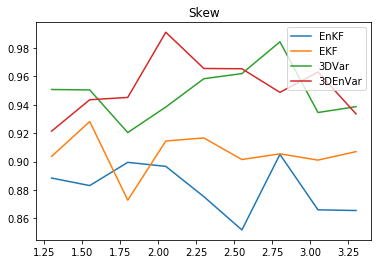

In [81]:
for key, val in skew_rmse.items():
    plt.plot(alphas, val, label=key)
plt.legend()
plt.title('Skew');

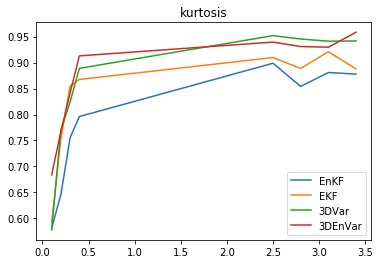

In [82]:
for key, val in kurt_rmse.items():
    plt.plot(deltas, val, label=key)
plt.legend()
plt.title('kurtosis');